In [160]:
import sys
sys.path.append('../SABR')

In [161]:
from SABR_montecarlo import *

In [162]:
from montecarlo import *
from heston import *
from sabr_approx import *

from matplotlib import pyplot as plt

In [163]:
def getMesh(Nu):
    un, h = np.linspace(0, 50, Nu + 1, retstep=True)
    un = un[:-1] + (h) / 2
    return un, h * np.ones((Nu, ))

In [164]:
def getPhiAB(u, tau, v, theta, rho, k, sig):
    
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    s = np.sinh(d*tau/2)
    c = np.cosh(d*tau/2)
    A1 = (1j*u + u**2)*s
    A2 = d*c + xi*s
    A = A1 / A2
    
    D = np.log(d) + (k-d)*tau/2 - np.log((d+xi)/2 + (d-xi)/2*np.exp(-d * tau))
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v + 2 * k * theta / sig ** 2 * D)
    return pred_phi

In [165]:
def getPhiABder(u, tau, v, theta, rho, k, sig):
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    
    c = np.cosh(d * tau / 2)
    s = np.sinh(d * tau / 2)
    
    A1 = (1j * u + u ** 2) * s
    A2 = (d * c + xi * s)
    A = A1 / A2
    
    B = d * np.exp(k * tau / 2) / A2
    
    D = np.log(d) + (k - d) * tau / 2 - np.log( (d + xi)/2 + (d-xi)/2 * np.exp(-d*tau) )
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v + 2 * k * theta / sig ** 2 * D)
    
    der1 = -A
    der2 = 2 * k / sig ** 2 * D - k * rho * tau * 1j * u / sig
    
    d_rho = -1j * u * sig * xi / d

    A1_rho = -1j * u * sig * tau * xi / (2 * d) * (u ** 2 + 1j * u) * c
    A2_rho = -(2 + xi * tau) * sig * 1j * u / (2 * d) * (xi * c + d * s)
    
    B_rho = np.exp(k * tau / 2) * (d_rho - d * A2_rho / A2) / A2
    A_rho = (A1_rho - A * A2_rho) / A2
    
    D_rho = B_rho / B
       
    der3 = -k * theta * tau * 1j * u / sig - v * A_rho + 2 * k * theta / sig **2 * D_rho
    
    A_k = A_rho * 1j / (u * sig)
    B_k = tau / 2 * B + B_rho * 1j / (u * sig)
    D_k = B_k / B
    
    der4 = -theta * rho * tau * 1j * u / sig - v * A_k + 2 * theta / sig**2 * D + 2 * k * theta / sig ** 2 * D_k
    
    d_sig = (sig * (1j * u + u ** 2) + rho * 1j * u * (sig * rho * 1j * u - k)) / d
    A1_sig = (1j * u + u ** 2) * tau / 2 * c * d_sig
    A2_sig = d_sig * ( c * (1 + xi * tau / 2) + d * tau / 2 * s) - s * rho * 1j * u
    
    A_sig = (A1_sig - A * A2_sig) / A2
    
    D_sig = d_sig / d - A2_sig / A2
    
    der5 = k * theta * rho * tau * 1j * u / sig ** 2 - v * A_sig - 4 * k * theta / sig**3 * D\
        + 2 * k * theta / sig ** 2 * D_sig
    
    return pred_phi, [der1, der2, der3, der4, der5]

In [166]:
def calc_int(F, h, dirs):
    I = np.sum( (F * h).real, axis=-1, keepdims=True) / np.pi
    Is = []
    for i in range(len(dirs)):
        Is.append( np.sum( (F * h * dirs[i]).real, axis=-1, keepdims=True) / np.pi )
    return I, Is

In [178]:
def getOptionPriceAB(S, K, Nu, tau, r, heston_params_list):
    
    K = K.reshape(-1, 1)

    Nk = K.size

    un, hn = getMesh(Nu)

    un = un.reshape(1, -1)
    hn = hn.reshape(1, -1)
    
    xn = np.log(S * np.exp(r * tau) / K)
    
    phi  = np.ones((1, Nu), complex)
    phiT = np.ones((1, Nu), complex)
    
    for i in range(len(heston_params_list) // 5):
        v, theta, rho, k, sig = heston_params_list[5 * i : 5 * i + 5]
        params = {"v":v, "theta":theta, "rho":rho, "k":k, "sig":sig}

        _phi = getPhiAB(un     , tau, **params)
        _phiT = getPhiAB(un - 1j, tau, **params)
        
        phi  *= _phi
        phiT *= _phiT
        
        
    F1 = np.exp(1j * un * xn) * phi  / (1j * un)
    F2 = np.exp(1j * un * xn) * phiT / (1j * un)

    I1 = np.sum( (F1 * hn).real, axis=-1, keepdims=True ) / np.pi
    I2 = np.sum( (F2 * hn).real, axis=-1, keepdims=True ) / np.pi

    P1 = 0.5 + I1
    P2 = 0.5 + I2
    res = S * P2 - np.exp(-r * tau) * K * P1
    return res.reshape(-1)

In [179]:
def getOptionPriceABDer(S, K, Nu, tau, r, heston_params_list):
    
    K = K.reshape(-1, 1)

    Nk = K.size

    un, hn = getMesh(Nu)

    un = un.reshape(1, -1)
    hn = hn.reshape(1, -1)
    
    xn = np.log(S * np.exp(r * tau) / K)
    
    phi  = np.ones((1, Nu), complex)
    phiT = np.ones((1, Nu), complex)
    
    ders  = []
    dersT = []
    
    for i in range(len(heston_params_list) // 5):
        v, theta, rho, k, sig = heston_params_list[5 * i : 5 * i + 5]
        params = {"v":v, "theta":theta, "rho":rho, "k":k, "sig":sig}

        _phi,  _ders  = getPhiABder(un     , tau, **params)
        _phiT, _dersT = getPhiABder(un - 1j, tau, **params)
        
        phi  *= _phi
        phiT *= _phiT
        
        ders  += _ders
        dersT += _dersT
        
        
    F1 = np.exp(1j * un * xn) * phi  / (1j * un)
    F2 = np.exp(1j * un * xn) * phiT / (1j * un)

    I1, Ders1 = calc_int(F1, hn, ders)
    I2, Ders2 = calc_int(F2, hn, dersT)

    P1 = 0.5 + I1
    P2 = 0.5 + I2
    res = S * P2 - np.exp(-r * tau) * K * P1
    
    res_der = []
    for der1, der2 in zip(Ders1, Ders2):
        tmp = S * der2 - np.exp(-r * tau) * K * der1
        res_der.append( tmp.reshape(-1) )
    return res.reshape(-1), res_der

In [180]:
from scipy import stats as sps
from scipy.optimize import root_scalar

def BS(K, S, r, tau, vol):
    F = S * np.exp(r * tau)
    d1 = (np.log(F / K) + 0.5 * vol ** 2 * tau) \
                / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    
    D = np.exp(-r * tau)
    call_price =  D *  ( F * sps.norm.cdf(d1) - K * sps.norm.cdf(d2) )
    return call_price


def getIV(call_prices, Ks, S, r, tau):
    res = []
    for call_price, K in zip(call_prices, Ks):
        def foo(vol):
            call_price_ = BS(K, S, r, tau, vol)
            return call_price_ - call_price
 
        v0 = 1e-15
        v1 = 100
        br = foo(v0) <= 0 and foo(v1) >= 0
        vol = np.nan
        if br:
            vol = root_scalar(foo, bracket=[v0, v1], method='bisect').root
        res.append( vol )
    return np.asarray(res)

In [181]:
def getOptionSurface(S, Kn, Nu, Tn, r, heston_params_list):
    Nk = len(Kn)
    Nt = len(Tn)
    res = np.zeros((Nk, Nt))
    for t, tau in enumerate(Tn):
        res[:, t] = getOptionPriceAB(S, Kn, Nu, tau, r, heston_params_list)
    return res

In [182]:
def getVolatilitySurface(S, Kn, Nu, Tn, r, heston_params_list):
    Nk = len(Kn)
    Nt = len(Tn)
    C = np.zeros((Nk, Nt))
    IV = np.zeros((Nk, Nt))
    for t, tau in enumerate(Tn):
        C[:, t] = getOptionPriceAB(S, Kn, Nu, tau, r, heston_params_list)
        IV[:, t] = getIV(C[:, t], Kn, S, r, tau)
    return C, IV

In [183]:
v0 = 0.175
theta = 0.15
rho = -0.8
k = 2.5
sig = 0.9

heston_params = (v0, theta, rho, k, sig)

S0 = 1.0
K = 1.0
T = 1.5

Kn = K * np.exp( np.linspace(-np.log(10), np.log(5), 100) )
Sn = S0 * np.exp( np.linspace(-np.log(10), np.log(2), 120) )

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 100
Nu = 50
tn = np.linspace(0, T, Nt)


x0 = np.log(S0)

In [184]:
C1 = getOptionPrice(S0, Kn, Nu, T, r, k, sig, theta, rho, v0)

C2 = getOptionPriceAB(S0, Kn, Nu, T, r, heston_params)

In [185]:
payoff = np.maximum(S0 - Kn, 0.0)

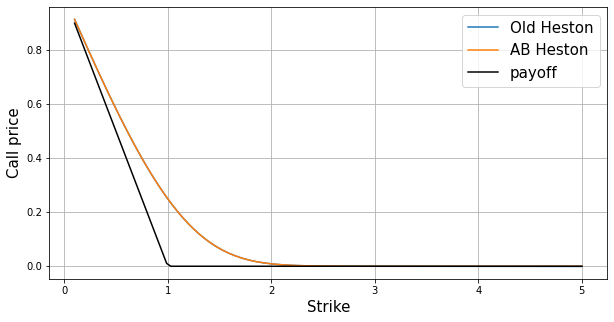

In [186]:
plt.figure(figsize=(10, 5))
plt.plot(Kn, C1, label='Old Heston')
plt.plot(Kn, C2, label='AB Heston')
plt.plot(Kn, np.maximum(S0 - Kn, 0.0), c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("Call price", fontsize=15)
None

In [401]:
r = 0.0

k_0 = 2.5
sig_0 = 0.9
theta_0 = 0.15
rho_0 = -0.2
v0_0 = 0.175

heston_params_0 = (v0_0, theta_0, rho_0, k_0, sig_0)
heston_params_0_list = heston_params_0

S0 = 1.0
K0 = 1.0
T = 1.0

Nk = 10
Kn = K0 + np.linspace(-0.8, 0.8, Nk) ** 3

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 5
Tn = T * np.linspace(0.5, T * 2.0, Nt)

Nu = 100

payoff = np.maximum(0.0, S0 - Kn).reshape(-1, 1)

In [402]:
C0 = getOptionSurface(S0, Kn, Nu, Tn, r, heston_params_0_list)

In [403]:
C0, vol0 = getVolatilitySurface(S0, Kn, Nu, Tn, r, heston_params_0_list)

In [404]:
X, Y = np.meshgrid(Tn, Kn)

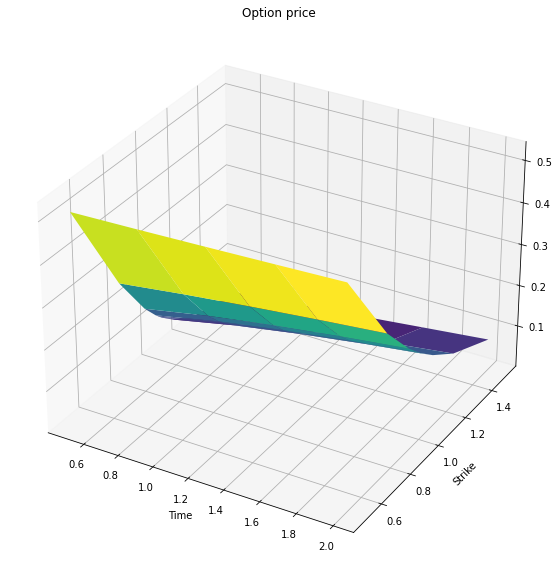

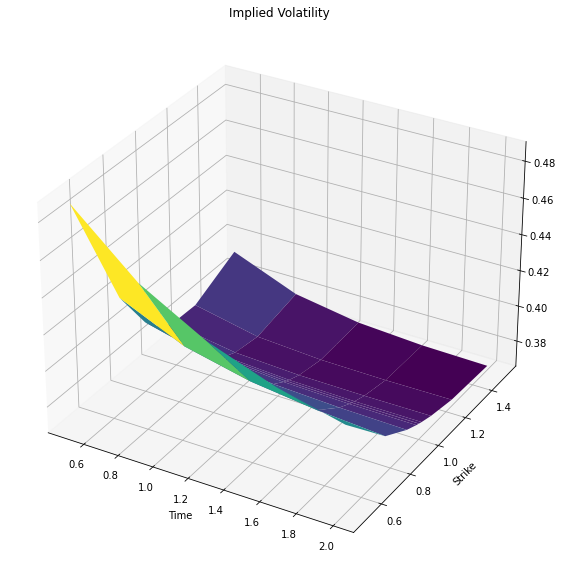

In [405]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, C0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Option price')
plt.xlabel("Time")
plt.ylabel("Strike")
None

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, vol0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Implied Volatility')
plt.xlabel("Time")
plt.ylabel("Strike")
None

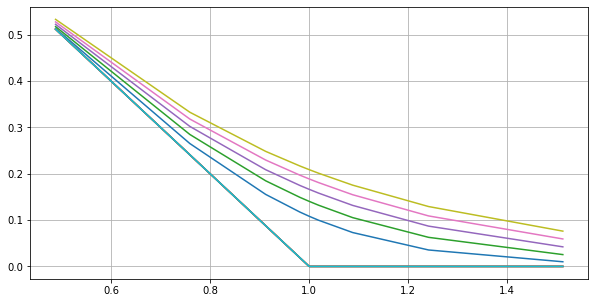

In [406]:
plt.figure(figsize=(10, 5))
payoff = np.maximum(0.0, S0 - Kn)
plt.plot()
for t in range(0, Nt):
    plt.plot(Kn, C0[:, t])
    plt.plot(Kn, payoff)
plt.grid()

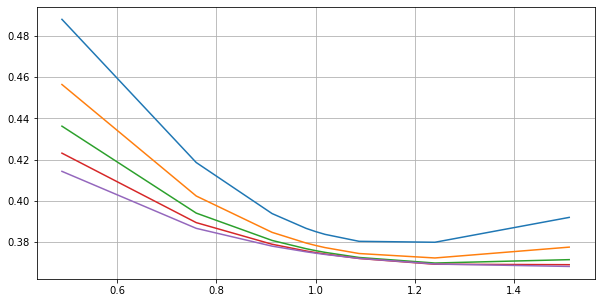

In [407]:
plt.figure(figsize=(10, 5))
for t in range(0, Nt):
    plt.plot(Kn, vol0[:, t])
plt.grid()

In [1060]:
def getResudalAndGrad(C0, S, Kn, Nu, Tn, r, heston_params_list):
    Nt = len(Tn)
    Nk = len(Kn)
    res = np.zeros((0, ))
    J = np.zeros((len(heston_params_list), 0))
    
    
    
    weights = np.ones((len(Kn), ))
    
    weights = 1 / (0.1 + (Kn - S) ** 2)
    
    for t in range(Nt):
        c, ders = getOptionPriceABDer(S0, Kn, Nu, Tn[t], r, heston_params_list)
        ders = np.asarray(ders)
        
        
        
        _res = c.reshape(-1) - C0[:, t].reshape(-1)
        res = np.r_[res, _res * weights]
        J = np.c_[J, ders @ np.diag(weights)]
    return res, J

In [1061]:
def my_clip(v0, theta, rho, k, sig):
    eps = 1e-3
    v0 = np.clip(v0, eps, 10)
    theta = np.clip(theta, eps, 10)
    rho = np.clip(rho, -1 + eps, 1 - eps)
    k = np.clip(k, eps, 10)
    sig = np.clip(sig, eps, 10)
    return np.asarray([v0, theta, rho, k, sig])
    
def LMAlgorithm(Niter, C0, S0, Kn, Nu, Tn, r, _heston_params):
    heston_params = _heston_params.copy()
    res, J = getResudalAndGrad(C0, S0, Kn, Nu, Tn, r, heston_params)
    F = np.linalg.norm(res)
    
    w = 5
    mu = w * np.max(np.diag(J))
    
    nu = 1.2
    
    fs = []
    
    for i in range(Niter):
        I = np.diag(np.diag(J @ J.T))
        dtheta = np.linalg.solve( mu * I + J @ J.T, J @ res )
        heston_params_new = heston_params - dtheta
        
        res_new, J_new = getResudalAndGrad(C0, S0, Kn, Nu, Tn, r, heston_params_new)
        
        F_new = np.linalg.norm(res_new)
        
        delta_L = np.dot( dtheta, mu * dtheta + J @ res )
        delta_F = F - F_new
        
        fs.append( F )
        
        if delta_L > 0 and delta_F > 0:
            J = J_new
            res = res_new
            F = F_new            
            for i in range(len(heston_params) // 5):
                heston_params[5 * i : 5 * (i + 1)] = my_clip(*heston_params_new[5 * i : 5 * (i + 1)])
            mu /= 1.2
        else:
            mu *= nu
            nu *= 1.2
            i -= 1
            continue
            
        eps1, eps2, eps3 = 1e-10, 1e-10, 1e-10
        stop = F < eps1 or np.linalg.norm(dtheta) / np.linalg.norm(heston_params) < eps3
        if stop:
            break        
    return heston_params, fs

In [1062]:
def gen_random_heston_params():
    v0 = np.random.rand(1) * 0.15 + 0.01
    theta = np.random.rand(1) * 0.15 + 0.01
    
    rho = -0.9 + (1.8) * np.random.rand(1)
    k = np.random.rand(1) * 2 + 1.0
    sig = np.random.rand(1) * 0.02 + 0.01
    
    return v0[0], theta[0], rho[0], k[0], sig[0]

In [1063]:
v0    = 0.175
theta = 0.02
rho   = 0.5
k     = 2.0
sig   = 0.5

heston_params_0 = np.asarray([*gen_random_heston_params(), *gen_random_heston_params()])

In [1064]:
heston_params_0

array([0.03876068, 0.07604283, 0.68083821, 2.90278205, 0.02002585,
       0.13558403, 0.01712121, 0.57012448, 1.93461048, 0.0134128 ])

In [1065]:
Niter = 100

In [1066]:
res, J = getResudalAndGrad(C0, S0, Kn, Nu, Tn, r, heston_params_0)

In [1067]:
heston_params, fs = LMAlgorithm(Niter, C0, S0, Kn, Nu, Tn, r, heston_params_0)

In [1068]:
print(*heston_params.round(5), sep='\t')

0.04819	0.09817	-0.2	2.50061	0.90038	0.12681	0.05183	-0.19999	2.50045	0.89988


In [1069]:
print(*[v0_0, theta_0, rho_0, k_0, sig_0], sep='\t')

0.175	0.15	-0.2	2.5	0.9


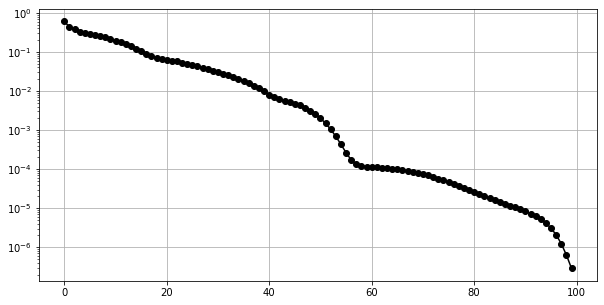

In [1070]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-ok')
plt.grid()

In [1071]:
F0 = S0 * np.exp(r * T)


alpha_sabr = 0.15
beta_sabr = 0.25
rho_sabr = 0.25

sig0_sabr = 0.3

In [1072]:
Cpetr, IVpetr = SabrApprox(Kn.reshape(-1, 1), F0, r, Tn.reshape(1, -1), sig0_sabr, alpha_sabr, beta_sabr, rho_sabr)

In [1073]:
Csabr = np.zeros((Nk, Nt))
IVsabr = np.zeros_like(Csabr)

tn = np.linspace(0, 1, 10)
Npaths = 10000


for t in range(Nt):
    F = SabrEulerModified(F0, sig0_sabr, Npaths, tn * Tn[t], alpha_sabr, beta_sabr, rho_sabr)
    payoff = np.exp(-r * Tn[t]) * np.maximum(F.reshape(-1, 1) - Kn.reshape(1, -1), 0.0)
    C = np.mean(payoff, axis=0)
    Csabr[:, t] = C.reshape(-1) 
    
    IVsabr[:, t] = getIV(C.reshape(-1), Kn.reshape(-1), S0, r, Tn[t])

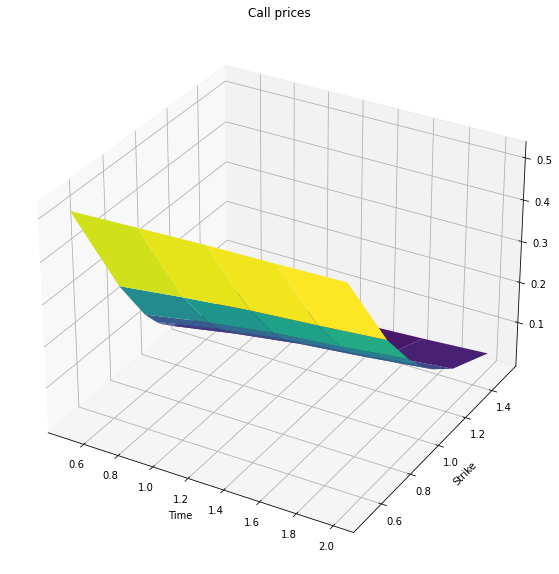

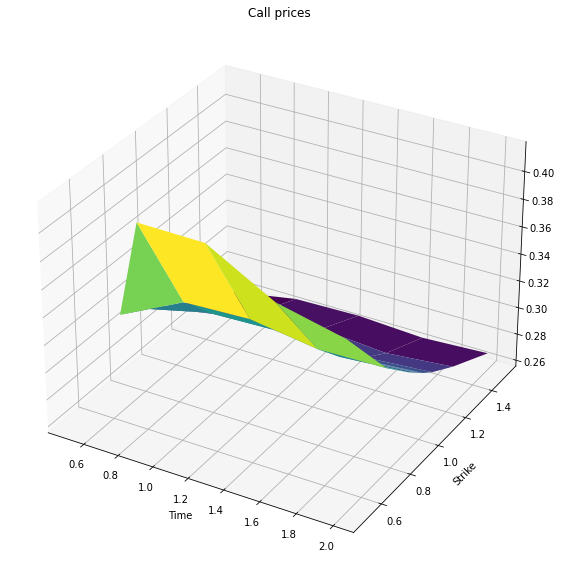

In [1074]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Csabr, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Call prices')
plt.xlabel("Time")
plt.ylabel("Strike")
None

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, IVsabr, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Call prices')
plt.xlabel("Time")
plt.ylabel("Strike")
None

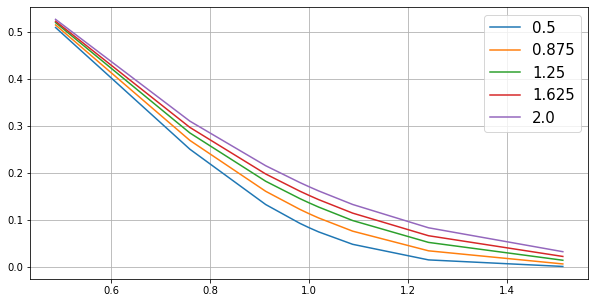

In [1075]:
plt.figure(figsize=(10, 5))
for t in range(0, Nt):
    plt.plot(Kn, Csabr[:, t], label=f'{Tn[t]}')
plt.legend(fontsize=15)
plt.grid()

In [1144]:
Ndim = 2

heston_params_0 = []

for i in range(Ndim):
    v0, theta, rho, k, sig = gen_random_heston_params()
    heston_params_0 += [v0, theta, rho, k, sig]
heston_params_0 = np.asarray(heston_params_0)

In [1145]:
heston_params, fs = LMAlgorithm(50, Csabr, S0, Kn, Nu, Tn, r, heston_params_0)

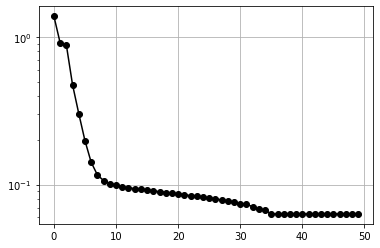

In [1146]:
plt.semilogy(fs, '-ok')
plt.grid()

In [1147]:
print(*heston_params.round(4))

0.001 0.0433 -0.1782 6.9316 0.001 0.0613 0.0802 -0.999 0.2836 0.2425


In [1148]:
C_heston = getOptionSurface(S0, Kn, Nu, Tn, r, heston_params)

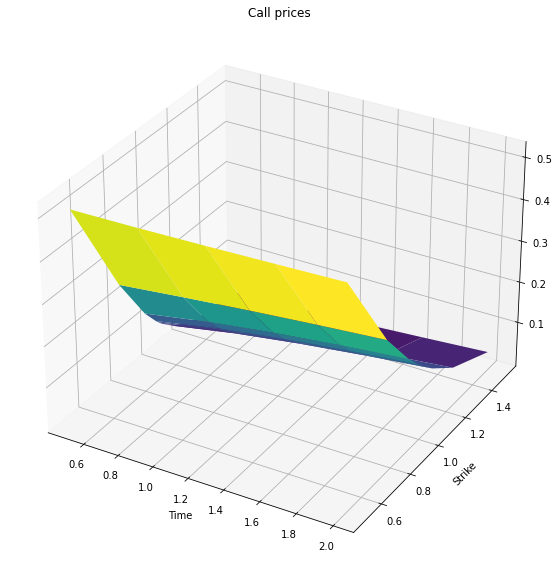

In [1149]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, C_heston, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Call prices')
plt.xlabel("Time")
plt.ylabel("Strike")
None

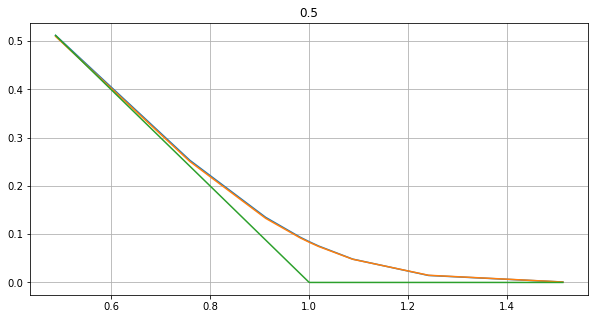

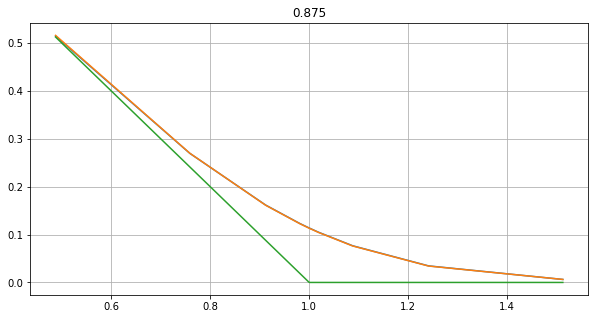

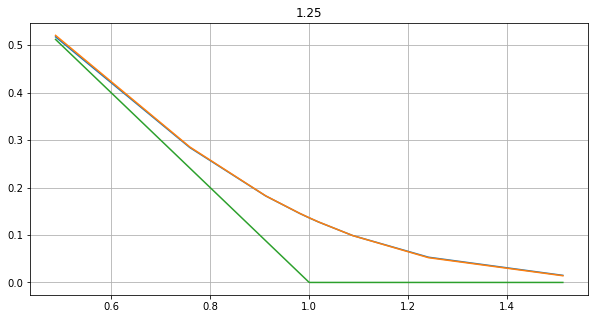

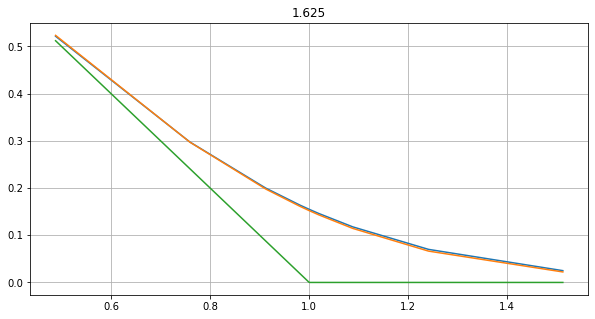

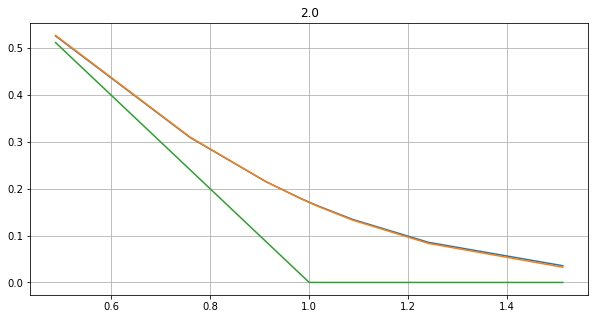

In [1150]:
for t in range(Nt):
    plt.figure(figsize=(10, 5))
    plt.plot(Kn, C_heston[:, t])
    plt.plot(Kn, Csabr[:, t])
    plt.plot(Kn, np.maximum(S0 - Kn, 0.0))
    plt.title(Tn[t])
    plt.grid()